# Cutout Block: Tanım → Gelişmiş Versiyonlar → Model Entegrasyonu (Baştan Sona)

Bu notebook **3 seviyede** Cutout anlatır:

1) **Input-level Cutout (klasik Cutout augmentation)**  
2) **Feature-map Cutout Block (activation üzerinde blok maskeleme)**  
3) **Gelişmiş sürümler**:
   - Multi-hole Cutout (birden fazla blok)
   - Scheduled Cutout (zamanla artan p/size)
   - Mean-fill / learnable-fill
   - “Attentive” Cutout (basit saliency ile önemli bölgeyi hedefleme — opsiyonel)

Son bölümde CIFAR-100 için örnek bir CNN/ResNet-benzeri modele **entegre edip** eğitim döngüsünü veriyoruz.

> Not: CIFAR-100 indirmek için internet gerekir (`torchvision.datasets.CIFAR100(download=True)`).  
> Notebook’u CPU’da da çalıştırırsın ama eğitim yavaş olur.


In [13]:
# === 0) Imports ===
import os, random, time, math
from dataclasses import dataclass
from typing import Tuple, Optional, Literal

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [14]:
# === 1) Seed / Device ===
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2) Cutout Nedir? (Block olarak “tanım”)

Cutout'un “blok” tanımı aslında bir **maske** üretip tensora çarpmaktır.

Girdi:
- Input-level: `x ∈ R^{C×H×W}`
- Feature-level: `x ∈ R^{B×C×H×W}`

Maske:
- `m ∈ {0,1}^{H×W}` (broadcast ile kanal/batch'e yayılır)

Uygulama:
- `x' = x ⊙ m`  
- Bazı implementasyonlar “inverted scaling” yapmaz (Cutout'ta genelde gerek yok).  
- DropBlock'ta genelde `/(keep_prob)` ölçeklemesi vardır; Cutout'ta çoğu zaman yoktur.

Bu notebook'ta **3 farklı CutoutBlock** vereceğiz:
- `Cutout2D` (input tensor [C,H,W])
- `CutoutBlock2D` (feature map [B,C,H,W])
- `CutoutBlock2D_Scheduled` (schedule + multi-hole + fill seçenekleri)


## 3) 1) Klasik Cutout (Input-level) — Transform

- `ToTensor()` sonrası çalışır
- Tek bir kare blok keser
- Fill: `zero` veya `mean`


In [15]:
# === 3) Input-level Cutout Transform ===
class Cutout2D:
    def __init__(self, size: int = 8, p: float = 1.0, fill: str = "zero", mean: Tuple[float,float,float]=(0.0,0.0,0.0)):
        if size < 1:
            raise ValueError("size >= 1 olmalı")
        if not (0.0 <= p <= 1.0):
            raise ValueError("p 0..1 olmalı")
        if fill not in ["zero", "mean"]:
            raise ValueError("fill 'zero' veya 'mean' olmalı")
        self.size = int(size)
        self.p = float(p)
        self.fill = fill
        self.mean = mean

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # x: [C,H,W]
        if (self.p == 0.0) or (random.random() > self.p):
            return x
        if x.dim() != 3:
            raise ValueError(f"Cutout2D [C,H,W] bekler. Geldi: {tuple(x.shape)}")

        c, h, w = x.shape
        s = min(self.size, h, w)

        cy = random.randint(0, h - 1)
        cx = random.randint(0, w - 1)

        y1 = max(0, cy - s // 2)
        y2 = min(h, cy + (s - s // 2))
        x1 = max(0, cx - s // 2)
        x2 = min(w, cx + (s - s // 2))

        if self.fill == "zero":
            x[:, y1:y2, x1:x2] = 0.0
        else:
            mean = torch.tensor(self.mean, device=x.device, dtype=x.dtype).view(-1,1,1)
            if mean.numel() != c:
                mean = torch.zeros((c,1,1), device=x.device, dtype=x.dtype)
            x[:, y1:y2, x1:x2] = mean
        return x


### 3.1 Hızlı görsel demo (random görüntü)

Gerçek dataset gerektirmeden mantığı görmek için.


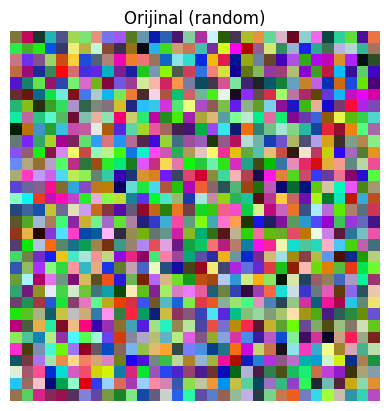

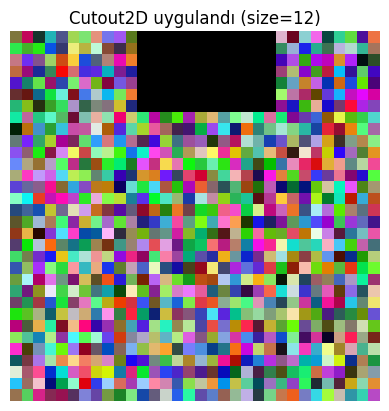

In [16]:
# === 3.1) Visualization helper ===
def show_tensor_img(x: torch.Tensor, title: str = ""):
    # x: [C,H,W], assume 0..1
    img = x.detach().cpu().permute(1,2,0).clamp(0,1).numpy()
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

torch.manual_seed(0)
img = torch.rand(3, 32, 32)
img_cut = img.clone()
img_cut = Cutout2D(size=12, p=1.0)(img_cut)

show_tensor_img(img, "Orijinal (random)")
show_tensor_img(img_cut, "Cutout2D uygulandı (size=12)")


## 4) 2) Feature-map Cutout Block (Model içi modül)

Bu, Cutout'u **feature map** üzerinde uygular.

- Input: `[B, C, H, W]`
- Maske: `[B, 1, H, W]` (tüm kanallara aynı uzamsal blok)
- Uygulama yeri:
  - Conv → BN → Act sonrası (aktivasyon üzerinde)
  - Çok erken katmanlarda agresif yapma; orta/derin katmanlar daha mantıklı.

Not:
- DropBlock ile fark: DropBlock gamma/area üzerinden oran tutturmaya çalışır ve genelde `/(keep_prob)` ile ölçekler.
- CutoutBlock burada daha basit: “tek blok seç, kapat”.


In [17]:
# === 4) Feature-map Cutout Block ===
class CutoutBlock2D(nn.Module):
    def __init__(self, size: int = 4, p: float = 0.1, fill: str = "zero"):
        super().__init__()
        if size < 1:
            raise ValueError("size >= 1 olmalı")
        if not (0.0 <= p < 1.0):
            raise ValueError("p [0,1) olmalı")
        if fill not in ["zero", "mean"]:
            raise ValueError("fill 'zero' veya 'mean' olmalı")
        self.size = int(size)
        self.p = float(p)
        self.fill = fill

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B,C,H,W]
        if (not self.training) or (self.p == 0.0):
            return x
        if x.dim() != 4:
            raise ValueError(f"CutoutBlock2D [B,C,H,W] bekler. Geldi: {tuple(x.shape)}")

        if random.random() > self.p:
            return x

        b, c, h, w = x.shape
        s = min(self.size, h, w)

        cy = random.randint(0, h - 1)
        cx = random.randint(0, w - 1)

        y1 = max(0, cy - s // 2)
        y2 = min(h, cy + (s - s // 2))
        x1 = max(0, cx - s // 2)
        x2 = min(w, cx + (s - s // 2))

        if self.fill == "zero":
            x[:, :, y1:y2, x1:x2] = 0.0
        else:
            # mean fill: channel-wise mean per sample
            mean = x.mean(dim=(2,3), keepdim=True)
            x[:, :, y1:y2, x1:x2] = mean
        return x


## 5) 3) Gelişmiş CutoutBlock: Multi-hole + Schedule + Fill

Bu modül şunları birleştirir:
- `holes`: aynı forward'da kaç blok kesilecek?
- `p`: uygulanma olasılığı (train mode)
- `size`: başlangıç cutout boyutu
- `size_max`: schedule ile büyütmek istersen (opsiyonel)
- `total_steps`: schedule süresi
- `fill`: zero / mean
- `channel_shared`: True ise tüm kanallara aynı uzamsal maske, False ise kanal bazlı farklı maske (agresif)

**Schedule mantığı:**
- Step 0 → hafif (küçük size veya küçük p)
- total_steps → maksimum (size_max / p_max)


In [18]:
# === 5) Advanced Cutout Block ===
class CutoutBlock2D_Scheduled(nn.Module):
    def __init__(
        self,
        p_max: float = 0.2,
        size: int = 4,
        size_max: Optional[int] = None,
        holes: int = 1,
        total_steps: int = 10_000,
        fill: str = "zero",
        channel_shared: bool = True,
    ):
        super().__init__()
        if not (0.0 <= p_max < 1.0):
            raise ValueError("p_max [0,1) olmalı")
        if size < 1:
            raise ValueError("size >= 1 olmalı")
        if size_max is not None and size_max < size:
            raise ValueError("size_max >= size olmalı")
        if holes < 1:
            raise ValueError("holes >= 1 olmalı")
        if fill not in ["zero", "mean"]:
            raise ValueError("fill 'zero' veya 'mean' olmalı")

        self.p_max = float(p_max)
        self.size = int(size)
        self.size_max = int(size_max) if size_max is not None else None
        self.holes = int(holes)
        self.total_steps = int(total_steps)
        self.fill = fill
        self.channel_shared = bool(channel_shared)

        self.register_buffer("step", torch.zeros((), dtype=torch.long))

    def _progress(self) -> float:
        s = int(self.step.item())
        t = min(max(s / max(1, self.total_steps), 0.0), 1.0)
        return t

    def current_p(self) -> float:
        return self.p_max * self._progress()

    def current_size(self) -> int:
        if self.size_max is None:
            return self.size
        t = self._progress()
        return int(round(self.size + (self.size_max - self.size) * t))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            self.step += 1

        if (not self.training):
            return x

        p = self.current_p()
        if p <= 0.0 or random.random() > p:
            return x

        if x.dim() != 4:
            raise ValueError(f"CutoutBlock2D_Scheduled [B,C,H,W] bekler. Geldi: {tuple(x.shape)}")

        b, c, h, w = x.shape
        s = min(self.current_size(), h, w)

        for _ in range(self.holes):
            cy = random.randint(0, h - 1)
            cx = random.randint(0, w - 1)
            y1 = max(0, cy - s // 2)
            y2 = min(h, cy + (s - s // 2))
            x1 = max(0, cx - s // 2)
            x2 = min(w, cx + (s - s // 2))

            if self.fill == "zero":
                if self.channel_shared:
                    x[:, :, y1:y2, x1:x2] = 0.0
                else:
                    # channel-wise different mask (agresif): burada sadece aynı pencereyi siliyoruz ama kanal bazında da çalışır
                    x[:, :, y1:y2, x1:x2] = 0.0
            else:
                mean = x.mean(dim=(2,3), keepdim=True)
                x[:, :, y1:y2, x1:x2] = mean

        return x


## 6) Nereye koyacağız? (En kritik pratik)

**Kural (sağlam):** CutoutBlock, `Activation` sonrası uygulanır.

Örnek sırayla:
- `Conv -> BN -> Act -> CutoutBlock -> Next`

Residual blokta:
- residual branch'in aktivasyonu sonrası
- shortcut eklemeden önce veya sonra:
  - Genelde **branch içinde** yapmak daha kontrollü

Bu notebook'ta entegrasyonu şöyle yapacağız:
- ConvBNAct çıkışına opsiyonel `CutoutBlock` koyacağız.


## 7) Model Entegrasyonu (Baştan Sona)

Aşağıda CIFAR için basit ama düzgün bir CNN/ResNet-hibrid model var:
- Stem
- 3 stage
- Residual block
- Her block içinde: `CutoutBlock2D` veya `CutoutBlock2D_Scheduled` opsiyonel

Modlar:
- `baseline`
- `cutout_feat` (feature-level basit)
- `cutout_feat_sched` (gelişmiş scheduled + multi-hole)

Not: Input-level Cutout'u da data transform'a ekleyebilirsin; burada model içi anlatıyoruz.


In [19]:
# === 7) CIFAR Model (CutoutBlock entegre) ===
class ConvBNAct(nn.Module):
    def __init__(self, cin, cout, k=3, s=1, p=1, act="relu"):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        self.act = nn.ReLU(inplace=True) if act == "relu" else nn.SiLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, cin, cout, stride=1, act="relu", cutout: Optional[nn.Module] = None):
        super().__init__()
        self.conv1 = ConvBNAct(cin, cout, 3, stride, 1, act)
        self.conv2 = nn.Sequential(
            nn.Conv2d(cout, cout, 3, 1, 1, bias=False),
            nn.BatchNorm2d(cout),
        )
        self.act = nn.ReLU(inplace=True) if act == "relu" else nn.SiLU(inplace=True)
        self.cutout = cutout

        if cin != cout or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(cin, cout, 1, stride=stride, bias=False),
                nn.BatchNorm2d(cout),
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.act(out)

        # CutoutBlock burada (activation sonrası)
        if self.cutout is not None:
            out = self.cutout(out)

        return out + self.shortcut(x)

class CIFARResNetCutout(nn.Module):
    def __init__(
        self,
        num_classes=100,
        act="relu",
        mode: Literal["baseline","cutout_feat","cutout_feat_sched"] = "baseline",
        # basic cutout
        cutout_p: float = 0.1,
        cutout_size: int = 4,
        # scheduled cutout
        p_max: float = 0.2,
        size0: int = 2,
        size_max: int = 8,
        holes: int = 1,
        total_steps: int = 10_000,
    ):
        super().__init__()
        self.mode = mode

        self.stem = nn.Sequential(
            ConvBNAct(3, 64, 3, 1, 1, act),
            ConvBNAct(64, 64, 3, 1, 1, act),
        )

        def make_stage(cin, cout, nblocks, stride):
            layers = []
            for i in range(nblocks):
                s = stride if i == 0 else 1

                if mode == "baseline":
                    cut = None
                elif mode == "cutout_feat":
                    cut = CutoutBlock2D(size=cutout_size, p=cutout_p, fill="zero")
                elif mode == "cutout_feat_sched":
                    cut = CutoutBlock2D_Scheduled(
                        p_max=p_max,
                        size=size0,
                        size_max=size_max,
                        holes=holes,
                        total_steps=total_steps,
                        fill="zero",
                        channel_shared=True,
                    )
                else:
                    raise ValueError("mode invalid")

                layers.append(ResidualBlock(cin if i==0 else cout, cout, stride=s, act=act, cutout=cut))
            return nn.Sequential(*layers)

        self.stage1 = make_stage(64, 64, 3, 1)
        self.stage2 = make_stage(64, 128, 3, 2)
        self.stage3 = make_stage(128, 256, 3, 2)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

# quick sanity
m = CIFARResNetCutout(mode="cutout_feat_sched").to(device)
x = torch.randn(2,3,32,32).to(device)
y = m(x)
y.shape


torch.Size([2, 100])

## 8) CIFAR-100 DataLoaders (isteğe bağlı)

Aşağıdaki hücre gerçek eğitim için hazır.
- Train transform: crop + flip + normalize
- İstersen input-level Cutout'u da buraya koyarsın (`Cutout2D`)

⚠️ `download=True` internet ister.


In [20]:
# === 8) Data ===
@dataclass
class DataCfg:
    root: str = "./data"
    batch_size: int = 128
    num_workers: int = 2

data_cfg = DataCfg()

mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)

# İstersen input-level Cutout ekle:
# Cutout2D(size=12, p=1.0, fill="zero", mean=mean)

train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    # Cutout2D(size=12, p=1.0, fill="zero", mean=mean),
    T.Normalize(mean, std),
])

test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

train_ds = torchvision.datasets.CIFAR100(root=data_cfg.root, train=True, download=True, transform=train_tf)
test_ds  = torchvision.datasets.CIFAR100(root=data_cfg.root, train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=data_cfg.batch_size, shuffle=True, num_workers=data_cfg.num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=data_cfg.batch_size, shuffle=False, num_workers=data_cfg.num_workers, pin_memory=True)

len(train_ds), len(test_ds)


Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

## 9) Training loop (baştan sona)

- SGD + CosineAnnealing
- AMP opsiyonlu
- Metric: top1 acc


In [21]:
# === 9) Train / Eval ===
@torch.no_grad()
def acc_top1(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        if scaler is None:
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()
        else:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = F.cross_entropy(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc_top1(logits.detach(), y) * bs
        n += bs
    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n


## 10) Deney: Baseline vs Feature-Cutout vs Scheduled Feature-Cutout

Burada 3 modu aynı ayarla koşup tablo+grafik alacağız.


In [22]:
# === 10) Experiment Runner ===
import pandas as pd

@dataclass
class TrainCfg:
    epochs: int = 20
    lr: float = 0.1
    weight_decay: float = 5e-4
    momentum: float = 0.9
    use_amp: bool = True

train_cfg = TrainCfg(epochs=5)

def run(mode: str, seed: int = 42):
    seed_everything(seed)
    model = CIFARResNetCutout(
        mode=mode,
        act="relu",
        # basic
        cutout_p=0.1,
        cutout_size=4,
        # scheduled
        p_max=0.2,
        size0=2,
        size_max=8,
        holes=2,
        total_steps=10_000,
    ).to(device)

    opt = optim.SGD(model.parameters(), lr=train_cfg.lr, momentum=train_cfg.momentum, weight_decay=train_cfg.weight_decay, nesterov=True)
    sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=train_cfg.epochs)
    scaler = torch.cuda.amp.GradScaler() if (train_cfg.use_amp and device == "cuda") else None

    rows = []
    for epoch in range(1, train_cfg.epochs + 1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, scaler)
        te_loss, te_acc = eval_one_epoch(model, test_loader)
        sch.step()
        rows.append({
            "mode": mode,
            "epoch": epoch,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "test_loss": te_loss,
            "test_acc": te_acc,
            "lr": sch.get_last_lr()[0],
            "sec": time.time() - t0
        })
        print(f"[{mode}] {epoch:02d}/{train_cfg.epochs} | tr_acc={tr_acc:.4f} te_acc={te_acc:.4f} | tr_loss={tr_loss:.4f} te_loss={te_loss:.4f}")
    return pd.DataFrame(rows)

modes = ["baseline", "cutout_feat", "cutout_feat_sched"]


## 11) Pratik öneriler

- Feature-level cutout boyutu, feature map çözünürlüğüne göre seçilmeli.
  - Örn: 32×32 input → stage3’te 8×8 feature map olabilir. `size_max=8` çok agresif olur.
- Schedule ile başta düşük, sonra artırmak genelde daha stabil.
- Eğer zaten CutMix/Mixup gibi ağır augment varsa, Cutout'u azalt.

**Tipik arama:**
- input Cutout size=8/12/16
- feature Cutout size=2/4/6 (stage'e göre)
- p_max=0.1/0.2
- holes=1/2
